In [1]:
pip install -q tensorflow-gpu

     |████████████████████████████████| 320.4MB 50kB/s 


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

cifar = tf.keras.datasets.cifar10


In [3]:
(X_train, y_train),(X_test, y_test) = cifar.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0 #range 0-1 and float type

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
y_train[0]

array([6], dtype=uint8)

In [5]:
y_train, y_test = y_train.flatten(), y_test.flatten()
y_train[0]

6

In [6]:
print(X_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000,)


In [7]:
set(y_train) #we have 10 classes to consider

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [12]:
#building the model using functional API 

i = Input(shape=X_train[0].shape) #[0] to get rid of the need to specify the element indices

x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x) #no dropouts between convolutions, that makes no sense since we need to keep it as detailes as possible

x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

#x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(len(set(y_train)), activation = 'softmax')(x)

model = Model(i,x)

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])

In [14]:
#adding augmentation 
batch_size = 32 #thats the tf default anyway

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1,
                                                                 rotation_range = 90, horizontal_flip = True) #this is quite brutal for such an architecture
train_generator = data_generator.flow(X_train, y_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size #must be integer or None, we want to see every image

conv = model.fit(train_generator, validation_data=(X_test, y_test), steps_per_epoch = steps_per_epoch, epochs = 50)

Epoch 1/50
1562/1562 [==============================] - 54s 34ms/step - loss: 1.7978 - accuracy: 0.3655 - val_loss: 1.5388 - val_accuracy: 0.4384
Epoch 2/50
1562/1562 [==============================] - 54s 34ms/step - loss: 1.4647 - accuracy: 0.4724 - val_loss: 1.5097 - val_accuracy: 0.4744
Epoch 3/50
1562/1562 [==============================] - 54s 34ms/step - loss: 1.3223 - accuracy: 0.5313 - val_loss: 1.2569 - val_accuracy: 0.5676
Epoch 4/50
1562/1562 [==============================] - 54s 34ms/step - loss: 1.2333 - accuracy: 0.5650 - val_loss: 1.2519 - val_accuracy: 0.5852
Epoch 5/50
1562/1562 [==============================] - 53s 34ms/step - loss: 1.1540 - accuracy: 0.5955 - val_loss: 1.2543 - val_accuracy: 0.5923
Epoch 6/50
1562/1562 [==============================] - 54s 35ms/step - loss: 1.0842 - accuracy: 0.6207 - val_loss: 1.0872 - val_accuracy: 0.6321
Epoch 7/50
1562/1562 [==============================] - 54s 34ms/step - loss: 1.0333 - accuracy: 0.6426 - val_loss: 1.0505 -

In [16]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)       

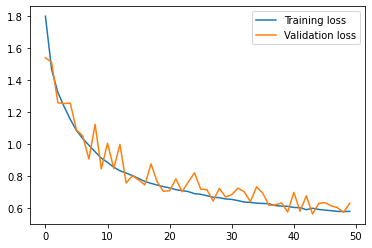

In [17]:
plt.plot(conv.history['loss'], label = 'Training loss')
plt.plot(conv.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

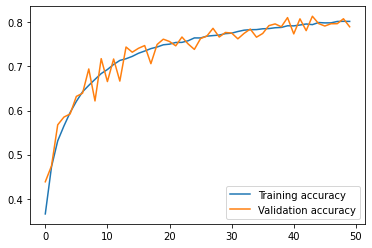

In [18]:
plt.plot(conv.history['accuracy'], label = 'Training accuracy')
plt.plot(conv.history['val_accuracy'], label = 'Validation accuracy')
plt.legend()
plt.show()

CM without Normalization
[[781  35  36  16  17   0   5   4  69  37]
 [  4 959   1   2   0   0   2   0  13  19]
 [ 36  15 755  51  50  12  45   5  15  16]
 [ 18  19  48 718  34  39  43   8  33  40]
 [  9   3  80  45 787   4  45  11   8   8]
 [  7  17  57 187  53 566  38  21  30  24]
 [  3  10  25  61  20   2 855   1  11  12]
 [ 21  15  34  27 114  14  10 728   7  30]
 [ 29  32   8   5   5   0   0   1 898  22]
 [  8 112   0   4   3   0   1   0  19 853]]


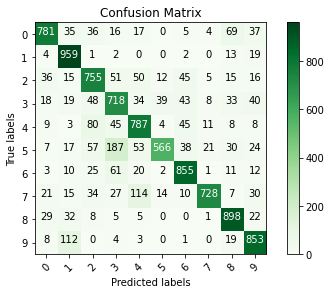

In [21]:
#lovely conf matrix function
from sklearn.metrics import confusion_matrix
import itertools

def plot_cm(y_real, y_pred, normalize = False, title='Confusion Matrix',cmap=plt.cm.Greens):
  cm = confusion_matrix(y_real, y_pred)
  classes = list(range(len(set(y_real))))
  if normalize:
    cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print('CM without Normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  ticks = np.arange(len(classes))
  plt.xticks(ticks, classes, rotation = 45)
  plt.yticks(ticks, classes)
  fmt = '.2f' if normalize else 'd'
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = 'center', color = 'white' if cm [i,j]>threshold else 'black')
  plt.tight_layout()
  plt.ylabel('True labels')
  plt.xlabel('Predicted labels')
  plt.show()

preds = model.predict(X_test).argmax(axis=1) #we need the most probable class
plot_cm(y_test, preds)


In [19]:
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

Text(0.5, 1.0, 'True label: frog | Prediction: cat')

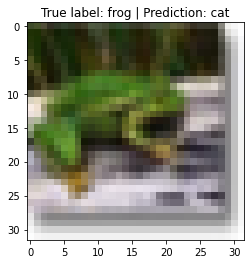

In [22]:
missed_indices = np.where(preds != y_test)[0]
rand = np.random.choice(missed_indices)
plt.imshow(X_test[rand])
plt.title('True label: %s | Prediction: %s' % (labels[y_test[rand]],labels[preds[rand]]))